Base math/data packages

In [1]:
import numpy as np
import pandas as pd

Gaussian Process Modeling packages

In [2]:
import gpflow
import tensorflow as tf

In [3]:
from gpflow.utilities import print_summary

Plotting package

In [4]:
import matplotlib.pyplot as plt

Notebook output parameters

In [5]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)

In [6]:
#tf.config.set_visible_devices([], 'GPU')

# Basic Gaussian Process regression model with `GPflow`

In [7]:
size = 500

In [8]:
X = np.linspace(0, 25, num = size)
Y = 5 * X + 3 * np.sin(X) * np.exp(0.1*X)

In [9]:
df_func = pd.DataFrame({
    'X': X,
    'Y': Y
})

Take n random samples from the function

In [10]:
n_sampl = 25

In [11]:
df_sampled = df_func.sample(n_sampl)
X_sampled = df_sampled['X'].to_numpy().reshape(-1, 1)

In [12]:
Y_sampled = df_sampled['Y'].to_numpy().reshape(-1, 1)

# Add noise to the output
mean, var = 0, 0.5
noise = np.random.normal(mean, var, size = Y_sampled.shape)

Y_sampled = Y_sampled + noise

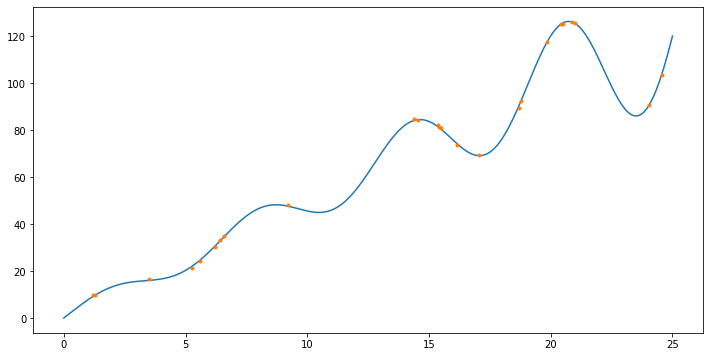

In [13]:
plt.figure()
plt.plot(X, Y)
plt.plot(X_sampled, Y_sampled, '.')
plt.show()

## Gaussian Process regression

In [14]:
k = gpflow.kernels.SquaredExponential() + gpflow.kernels.Linear()

In [15]:
print_summary(k)

╒═════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                        │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ Sum.kernels[0].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Sum.kernels[0].lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Sum.kernels[1].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
╘═════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═══

In [16]:
m = gpflow.models.GPR(
    data = (X_sampled, Y_sampled), 
    kernel = k, 
    mean_function = None
    )
print_summary(m)

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├───────

In [17]:
opt = gpflow.optimizers.Scipy()

In [18]:
opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=1000))
print_summary(m)

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 194.668     │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │   1.33927   │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ 

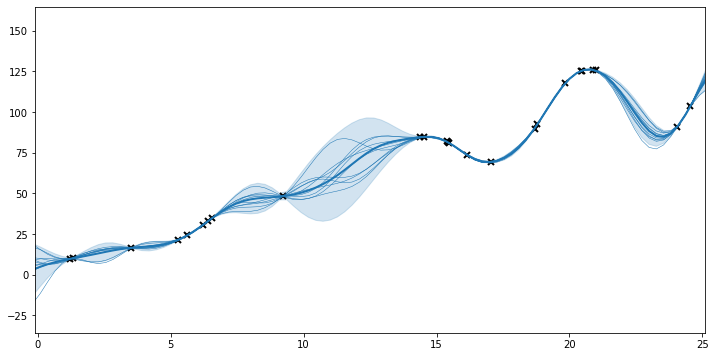

In [19]:
## generate test points for prediction
xx = np.linspace(-1, 26, 100).reshape(100, 1)  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)

## generate 10 samples from posterior
tf.random.set_seed(1)  # for reproducibility
samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot
plt.figure(figsize=(12, 6))
plt.plot(X_sampled, Y_sampled, "kx", mew=2)
plt.plot(xx, mean, "C0", lw=2)
plt.fill_between(
    xx[:, 0],
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,
)
plt.plot(xx, samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
#plt.plot(X, Y, color = 'darkorange', lw = 2)
_ = plt.xlim(-0.1, 25.1)